# Coverage Analysis

This notebook analyzes the coverage data from CSV files in the '5xcoverage_csv_files-600-300-3' directory. We will plot coverage over time for all results, grouped by experiment number.

## Import Required Libraries

First, let's import the libraries we'll need for our analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from glob import glob

# Set up the plotting style
plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 8]

## Load and Explore Data

In [2]:
# Define the base directory path
base_dir = 'data/noplateau/scratch/experiment-results'

# Get all coverage CSV files from the nested directory structure
csv_files = []
file_metadata = []

# Use glob to find all coverage_*.csv files in the nested structure
pattern = os.path.join(base_dir, '*', '*', 'results-*', 'logs', 'coverage_*.csv')
found_files = glob(pattern)

def get_module_name(file_path):
    # Read the actual module name from run-info.txt
    path_parts = file_path.split(os.sep)
    base_idx = path_parts.index('experiment-results')
    
    results_dir = os.path.join(*path_parts[:base_idx + 4])  # up to results-* folder
    run_info_path = os.path.join(results_dir, 'run-info.txt')
    
    module_name = path_parts[base_idx + 1]  # fallback to directory name
    if os.path.exists(run_info_path):
        try:
            with open(run_info_path, 'r') as f:
                for line in f:
                    if line.startswith('module-name:'):
                        module_name = line.split(':', 1)[1].strip()
                        break
        except Exception as e:
            print(f"Warning: Could not read module name from {run_info_path}: {e}")
    
    return module_name

for file_path in found_files:
    # Extract metadata from the path
    path_parts = file_path.split(os.sep)
    
    # Find the indices of the relevant parts
    try:
        base_idx = path_parts.index('experiment-results')

        module_name = get_module_name(file_path)
        module_run = path_parts[base_idx + 2]
        
        # Extract TOTAL_RUN from results-{TOTAL_RUN}
        results_part = path_parts[base_idx + 3]
        total_run = results_part.replace('results-', '')
        
        csv_files.append(file_path)
        file_metadata.append({
            'file_path': file_path,
            'module_name': module_name,
            'module_run': module_run,
            'total_run': total_run,
            'filename': os.path.basename(file_path)
        })
    except (ValueError, IndexError) as e:
        print(f"Could not parse path structure for: {file_path}")

print(f"Found {len(csv_files)} CSV files in {base_dir}")
print("Example files:", csv_files[:5] if len(csv_files) >= 5 else csv_files)

# Display metadata for first few files
if file_metadata:
    print("\nFile metadata examples:")
    for i, metadata in enumerate(file_metadata[:3]):
        print(f"File {i+1}: {metadata}")

Found 150 CSV files in data/noplateau/scratch/experiment-results
Example files: ['data/noplateau/scratch/experiment-results/flake8/0/results-1/logs/coverage_0.csv', 'data/noplateau/scratch/experiment-results/flake8/0/results-0/logs/coverage_0.csv', 'data/noplateau/scratch/experiment-results/flake8/1/results-6/logs/coverage_1.csv', 'data/noplateau/scratch/experiment-results/flake8/1/results-5/logs/coverage_1.csv', 'data/noplateau/scratch/experiment-results/flake8/2/results-11/logs/coverage_2.csv']

File metadata examples:
File 1: {'file_path': 'data/noplateau/scratch/experiment-results/flake8/0/results-1/logs/coverage_0.csv', 'module_name': 'flake8.options.aggregator', 'module_run': '0', 'total_run': '1', 'filename': 'coverage_0.csv'}
File 2: {'file_path': 'data/noplateau/scratch/experiment-results/flake8/0/results-0/logs/coverage_0.csv', 'module_name': 'flake8.main.debug', 'module_run': '0', 'total_run': '0', 'filename': 'coverage_0.csv'}
File 3: {'file_path': 'data/noplateau/scratch/e

In [3]:
# Let's look at the structure of the first file to understand the data
if csv_files:
    df_example = pd.read_csv(csv_files[0])
    print(f"Shape of first file: {df_example.shape}")
    print("Columns:")
    print(df_example.columns.tolist())
    print("\nFirst few rows:")
    display(df_example.head())

Shape of first file: (13, 6)
Columns:
['iteration', 'finish_timestamp', 'finish_total_time_used', 'iteration_type', 'best_coverage', 'coverage']

First few rows:


,iteration,finish_timestamp,finish_total_time_used,iteration_type,best_coverage,coverage
0,1,94,88,coverup,0,-1
1,2,105,96,diversity,0,-1
2,3,216,203,pynguin,28,28
3,4,287,271,coverup,28,28
4,5,307,288,diversity,28,28


## Process All Data Files

Now we'll load all the CSV files and combine them into a single DataFrame, extracting the experiment number and run information from the file names.

In [4]:
def extract_info_from_file_metadata(file_path):
    """Extract experiment info from file metadata"""
    # Find the corresponding metadata for this file
    for metadata in file_metadata:
        if metadata['file_path'] == file_path:
            total_run_num = int(metadata['total_run'])
            module_run_num = int(metadata['module_run'])
            module = metadata['module_name']
            return total_run_num, module_run_num, module
    return None, None, None

# Create an empty list to store all dataframes
all_dfs = []

# Process each CSV file
for file in csv_files:
    try:
        # Extract information from filename
        total_run_num, module_run_num, module = extract_info_from_file_metadata(file)
        
        if total_run_num is not None:
            # Read the CSV file
            df = pd.read_csv(file)
            
            # Add metadata columns
            df['total_run_num'] = total_run_num
            df['module_run_num'] = module_run_num
            df['module'] = module
            
            # Append to the list of dataframes
            all_dfs.append(df)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Combine all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined data shape: {combined_df.shape}")
    display(combined_df.head())
else:
    print("No data files were successfully processed")

Combined data shape: (1827, 9)


,iteration,finish_timestamp,finish_total_time_used,iteration_type,best_coverage,coverage,total_run_num,module_run_num,module
0,1,94,88,coverup,0,-1,1,0,flake8.options.aggregator
1,2,105,96,diversity,0,-1,1,0,flake8.options.aggregator
2,3,216,203,pynguin,28,28,1,0,flake8.options.aggregator
3,4,287,271,coverup,28,28,1,0,flake8.options.aggregator
4,5,307,288,diversity,28,28,1,0,flake8.options.aggregator


In [5]:
# For each module, extend runs that ended early with a flat line to the module's max iteration

# 1. Find the highest iteration number for each module
module_max_iter = combined_df.groupby('module')['iteration'].max().to_dict()

# 2. Prepare a list to collect new rows
rows_to_add = []

# 3. For each run (module_run_num) in each module, check if it ended early
for (module, module_run_num), group in combined_df.groupby(['module', 'module_run_num']):
    run_max_iter = group['iteration'].max()
    module_iter = module_max_iter[module]
    if run_max_iter < module_iter:
        # Get the row with the highest iteration for this run
        last_row = group[group['iteration'] == run_max_iter].iloc[-1].copy()
        # For all missing iterations, clone and modify as requested
        for missing_iter in range(run_max_iter + 1, module_iter + 1):
            new_row = last_row.copy()
            new_row['iteration'] = missing_iter
            rows_to_add.append(new_row)

# 4. Add the new rows to the dataframe
if rows_to_add:
    combined_df = pd.concat([combined_df, pd.DataFrame(rows_to_add)], ignore_index=True)

## Group Data by Experiment

Now, let's calculate statistics for each experiment - mean, min, and max coverage over time.

In [6]:
# First, let's ensure we have the right columns for our analysis
if 'combined_df' in locals():
    
    coverage_column = 'best_coverage'
    time_column = 'iteration'
    
    print(f"\nUsing '{coverage_column}' as the coverage measure and '{time_column}' as the time measure")

    # Group by module and time, then calculate statistics
    grouped = combined_df.groupby(['module', time_column])[coverage_column].agg(['mean', 'min', 'max']).reset_index()
    
    print("\nCalculated statistics by experiment and time:")
    display(grouped.head(20))
else:
    print("No combined dataframe available for analysis")


Using 'best_coverage' as the coverage measure and 'iteration' as the time measure

Calculated statistics by experiment and time:


,module,iteration,mean,min,max
0,docstring_parser.google,1,45.500000,28,87
1,docstring_parser.google,2,45.500000,28,87
2,docstring_parser.google,3,48.833333,28,87
3,docstring_parser.google,4,50.766667,28,87
4,docstring_parser.google,5,53.333333,28,88
5,docstring_parser.google,6,54.033333,28,88
6,docstring_parser.google,7,54.533333,28,89
7,docstring_parser.google,8,55.900000,28,89
8,docstring_parser.google,9,56.133333,28,89
9,docstring_parser.google,10,58.533333,28,91


In [7]:
# Let's explore the data to understand why we see drops in "best_coverage"
print("Exploring best_coverage behavior across the dataset...")

# Check if best_coverage ever decreases within a single file/run
decreasing_coverage_runs = []

for exp_num, group in combined_df.groupby(['module']):
    # Sort by iteration to ensure proper order
    group_sorted = group.sort_values('iteration')
    
    # Check if best_coverage ever decreases
    for i in range(1, len(group_sorted)):
        current_coverage = group_sorted.iloc[i]['best_coverage']
        previous_coverage = group_sorted.iloc[i-1]['best_coverage']
        
        if current_coverage < previous_coverage:
            decreasing_coverage_runs.append({
                'module': exp_num,
                'iteration': group_sorted.iloc[i]['iteration'],
                'previous_coverage': previous_coverage,
                'current_coverage': current_coverage,
                'drop_amount': previous_coverage - current_coverage
            })

if decreasing_coverage_runs:
    print(f"\nFound {len(decreasing_coverage_runs)} instances where best_coverage decreased within a run:")
    decreasing_df = pd.DataFrame(decreasing_coverage_runs)
    display(decreasing_df.head(10))
    
    print(f"\nSummary of coverage drops:")
    print(f"Total drops: {len(decreasing_coverage_runs)}")
    print(f"Average drop amount: {decreasing_df['drop_amount'].mean():.2f}")
    print(f"Max drop amount: {decreasing_df['drop_amount'].max()}")
    print(f"Modules with drops: {decreasing_df['module'].nunique()}")
else:
    print("\nNo instances found where best_coverage decreased within a run.")

# Let's also look at the difference between 'coverage' and 'best_coverage' columns
print("\n" + "="*50)
print("Analyzing difference between 'coverage' and 'best_coverage' columns:")

# Sample some data to see the relationship
sample_data = combined_df.sample(20, random_state=42)[['module', 'iteration', 'coverage', 'best_coverage']]
print("\nSample data showing coverage vs best_coverage:")
display(sample_data)

# Check if coverage is ever higher than best_coverage (which shouldn't happen)
coverage_issues = combined_df[combined_df['coverage'] > combined_df['best_coverage']]
if len(coverage_issues) > 0:
    print(f"\nFound {len(coverage_issues)} cases where 'coverage' > 'best_coverage' (unexpected):")
    display(coverage_issues[['module', 'iteration', 'coverage', 'best_coverage']].head())
else:
    print("\nNo cases found where 'coverage' > 'best_coverage' (as expected)")


Exploring best_coverage behavior across the dataset...

Found 477 instances where best_coverage decreased within a run:


,module,iteration,previous_coverage,current_coverage,drop_amount
0,"(docstring_parser.google,)",1,83,29,54
1,"(docstring_parser.google,)",1,82,75,7
2,"(docstring_parser.google,)",1,75,30,45
3,"(docstring_parser.google,)",1,30,29,1
4,"(docstring_parser.google,)",1,82,29,53
5,"(docstring_parser.google,)",1,84,30,54
6,"(docstring_parser.google,)",1,82,29,53
7,"(docstring_parser.google,)",1,87,28,59
8,"(docstring_parser.google,)",1,77,30,47
9,"(docstring_parser.google,)",1,30,28,2



Summary of coverage drops:
Total drops: 477
Average drop amount: 26.23
Max drop amount: 61
Modules with drops: 5

Analyzing difference between 'coverage' and 'best_coverage' columns:

Sample data showing coverage vs best_coverage:


,module,iteration,coverage,best_coverage
1307,pypara.accounting.journaling,5,73,81
170,flake8.main.debug,8,50,50
1809,semantic_release.ci_checks,10,96,96
1298,pypara.accounting.journaling,7,81,81
1845,docstring_parser.google,17,39,39
1739,semantic_release.ci_checks,2,94,94
2283,flake8.options.aggregator,11,24,28
1448,semantic_release.ci_checks,8,96,96
289,flake8.options.aggregator,9,24,28
1860,docstring_parser.google,17,40,40



No cases found where 'coverage' > 'best_coverage' (as expected)


In [8]:
# Analyze if mean, min, or max ever decrease within each module as iterations progress
decreasing_stats = []

for module in grouped['module'].unique():
    module_data = grouped[grouped['module'] == module].sort_values('iteration')
    
    # Check for decreasing mean
    for i in range(1, len(module_data)):
        current_row = module_data.iloc[i]
        previous_row = module_data.iloc[i-1]
        
        # Check if mean decreased
        if current_row['mean'] < previous_row['mean']:
            decreasing_stats.append({
                'module': module,
                'iteration': current_row['iteration'],
                'stat_type': 'mean',
                'previous_value': previous_row['mean'],
                'current_value': current_row['mean'],
                'decrease': previous_row['mean'] - current_row['mean']
            })
        
        # Check if min decreased
        if current_row['min'] < previous_row['min']:
            decreasing_stats.append({
                'module': module,
                'iteration': current_row['iteration'],
                'stat_type': 'min',
                'previous_value': previous_row['min'],
                'current_value': current_row['min'],
                'decrease': previous_row['min'] - current_row['min']
            })
        
        # Check if max decreased
        if current_row['max'] < previous_row['max']:
            decreasing_stats.append({
                'module': module,
                'iteration': current_row['iteration'],
                'stat_type': 'max',
                'previous_value': previous_row['max'],
                'current_value': current_row['max'],
                'decrease': previous_row['max'] - current_row['max']
            })

if decreasing_stats:
    decreasing_df = pd.DataFrame(decreasing_stats)
    print(f"Found {len(decreasing_stats)} instances where statistics decreased:")
    display(decreasing_df)
    
    # Summary by statistic type
    print("\nSummary by statistic type:")
    print(decreasing_df['stat_type'].value_counts())
    
    # Summary by module
    print("\nSummary by module:")
    print(decreasing_df['module'].value_counts())
    
    # Largest decreases
    print("\nLargest decreases:")
    print(decreasing_df.nlargest(10, 'decrease')[['module', 'iteration', 'stat_type', 'decrease']])
    
else:
    print("No instances found where mean, min, or max decreased within any module.")

# Also show some examples of the progression for each module
print("\n" + "="*70)
print("Sample progression for each module (first 5 iterations):")
for module in grouped['module'].unique():
    module_data = grouped[grouped['module'] == module].sort_values('iteration').head(5)
    print(f"\n{module}:")
    display(module_data[['iteration', 'mean', 'min', 'max']])

No instances found where mean, min, or max decreased within any module.

Sample progression for each module (first 5 iterations):

docstring_parser.google:


,iteration,mean,min,max
0,1,45.500000,28,87
1,2,45.500000,28,87
2,3,48.833333,28,87
3,4,50.766667,28,87
4,5,53.333333,28,88



flake8.main.debug:


,iteration,mean,min,max
17,1,0.000000,0,0
18,2,3.333333,0,50
19,3,50.000000,50,50
20,4,50.000000,50,50
21,5,50.000000,50,50



flake8.options.aggregator:


,iteration,mean,min,max
39,1,0.000000,0,0
40,2,0.000000,0,0
41,3,27.066667,0,28
42,4,27.066667,0,28
43,5,27.866667,24,28



pypara.accounting.journaling:


,iteration,mean,min,max
56,1,0.000000,0,0
57,2,0.000000,0,0
58,3,81.366667,81,92
59,4,81.366667,81,92
60,5,81.366667,81,92



semantic_release.ci_checks:


,iteration,mean,min,max
69,1,65.966667,50,97
70,2,65.966667,50,97
71,3,71.500000,56,97
72,4,74.133333,56,99
73,5,74.133333,56,99


## Plot Coverage Over Time

Now, we'll create plots to visualize the coverage over time for each experiment, showing the mean line and the min-max range as a shaded area.

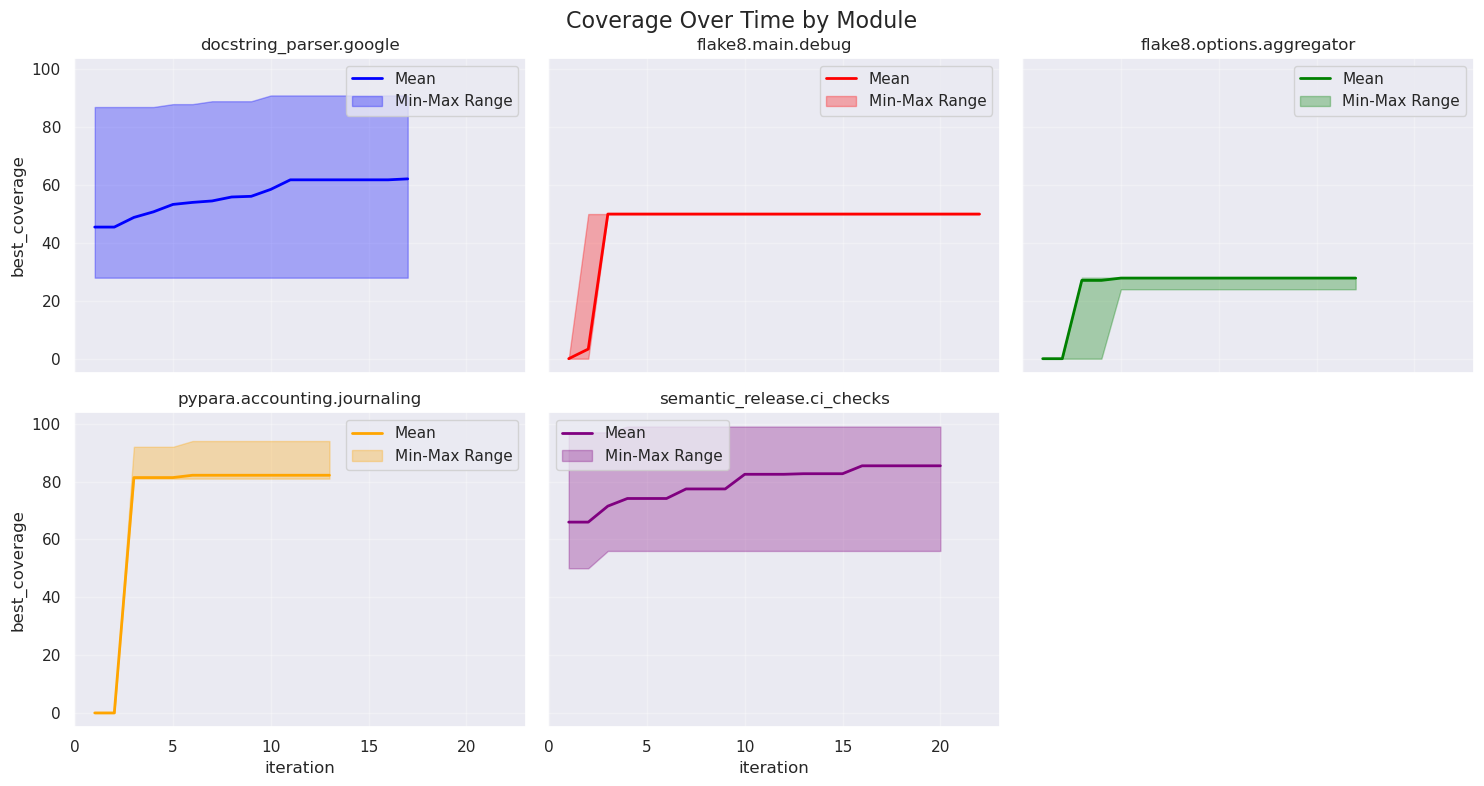

In [9]:
# Define colors for consistent plotting
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Plot with the original grouped data (no extension needed)
modules = sorted(grouped['module'].unique())
n_modules = len(modules)
n_cols = min(3, n_modules)
n_rows = (n_modules + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharex=True, sharey=True)
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, module in enumerate(modules):
    ax = axes[i]
    module_data = grouped[grouped['module'] == module]
    
    # Plot mean line
    ax.plot(module_data[time_column], module_data['mean'], 
            color=colors[i % len(colors)], 
            linewidth=2, 
            label='Mean')
    
    # Add shaded area for min-max range
    ax.fill_between(module_data[time_column], 
                   module_data['min'], 
                   module_data['max'], 
                   color=colors[i % len(colors)], 
                   alpha=0.3, 
                   label='Min-Max Range')
    
    ax.set_title(f'{module}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    if i % n_cols == 0:
        ax.set_ylabel(coverage_column)
    if i >= (n_rows - 1) * n_cols:
        ax.set_xlabel(time_column)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Coverage Over Time by Module', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/coverage_over_time_by_module.png', dpi=300)
plt.show()


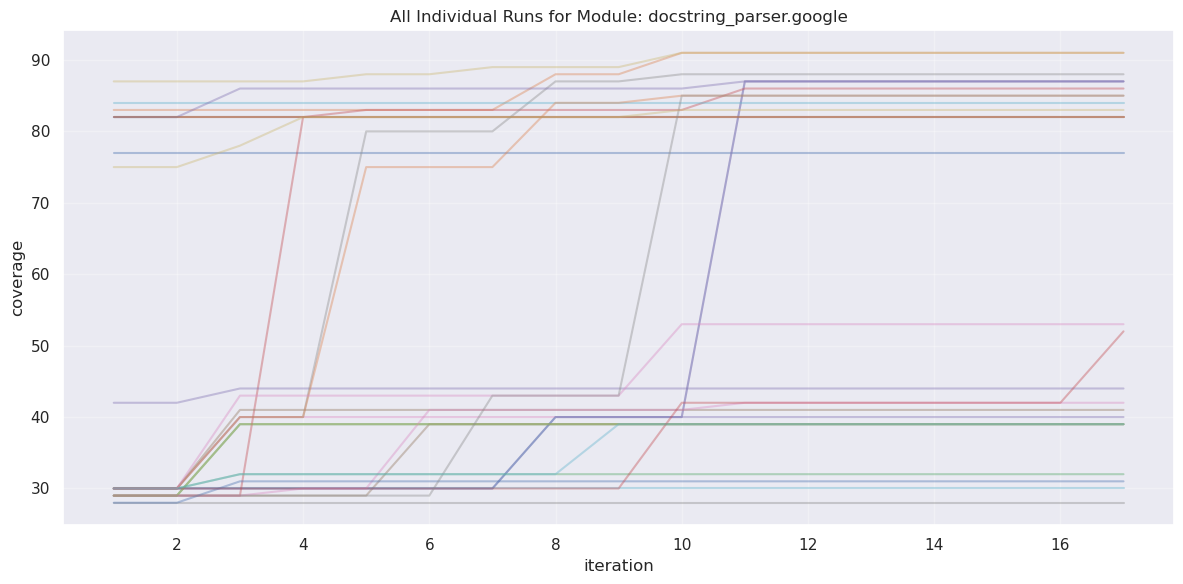

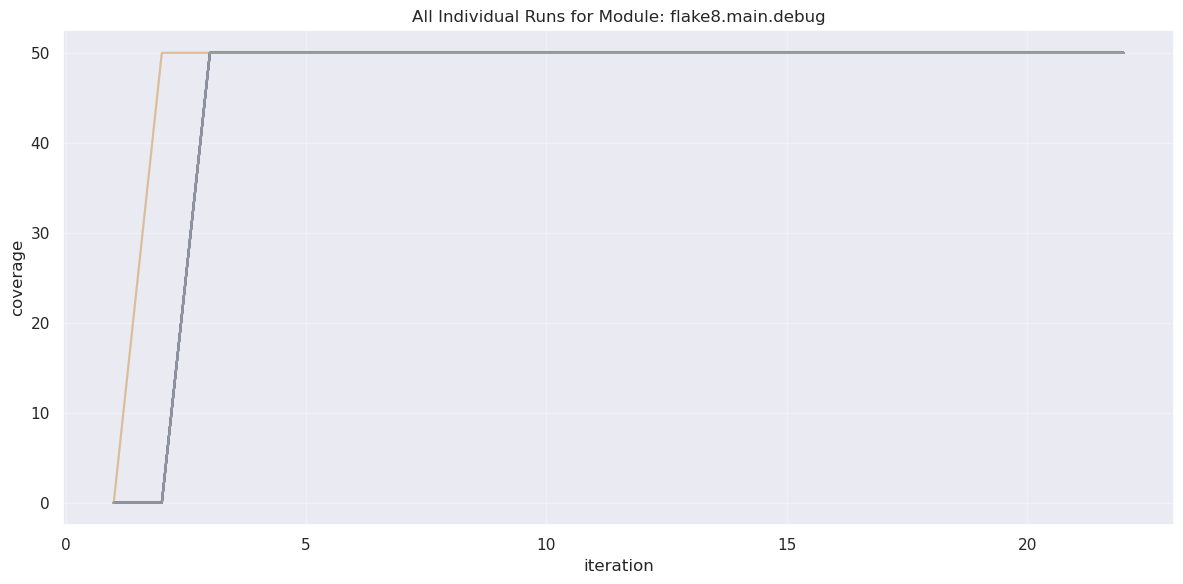

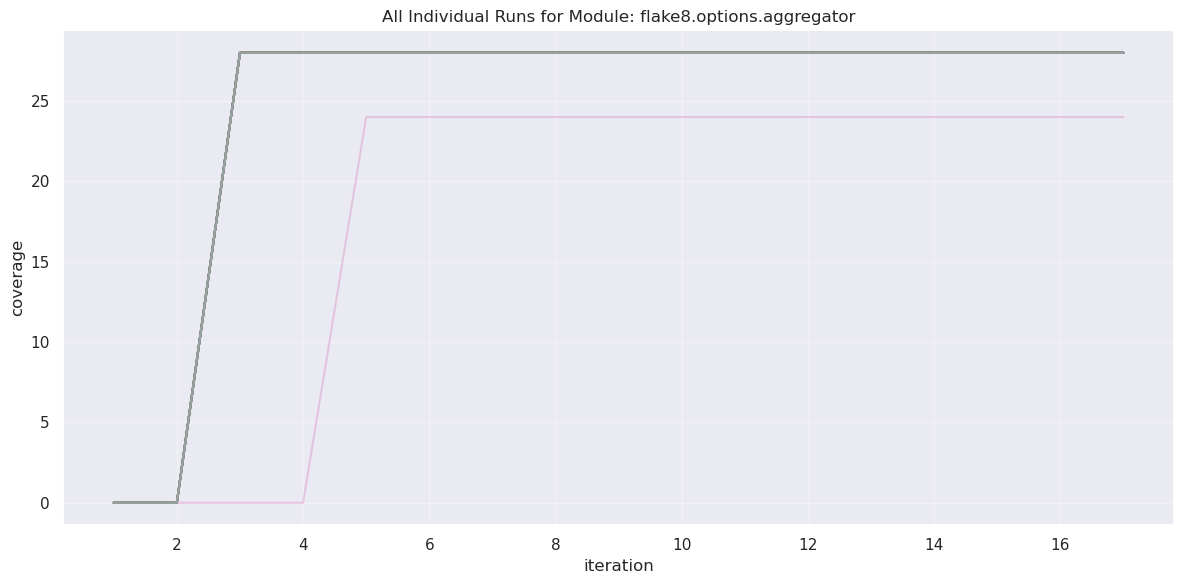

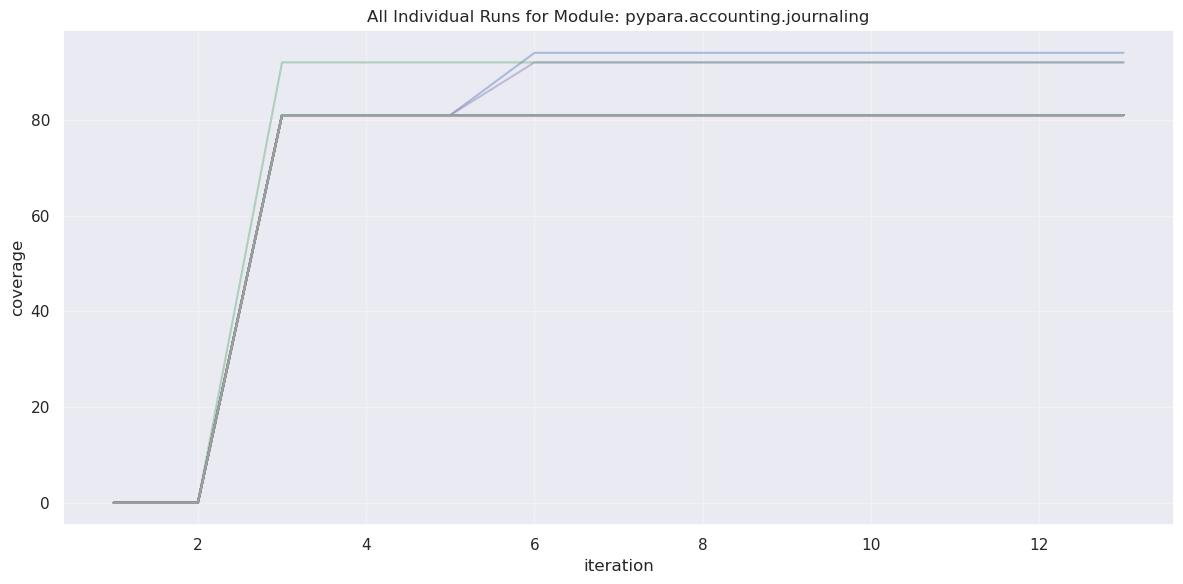

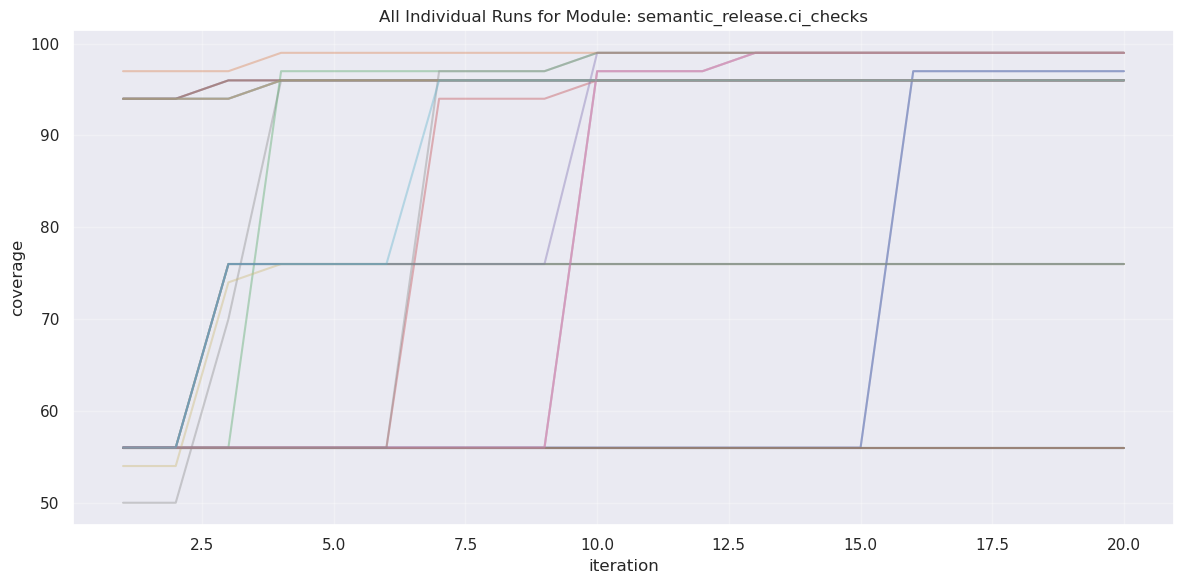

In [18]:
# Plot all individual runs for each module in one graph

for module in modules:
    plt.figure(figsize=(12, 6))
    module_data = combined_df[combined_df['module'] == module]
    for run_num, run_data in module_data.groupby('module_run_num'):
        plt.plot(run_data[time_column], run_data[coverage_column], alpha=0.4, label=f'Run {run_num}')
    plt.title(f'All Individual Runs for Module: {module}')
    plt.xlabel(time_column)
    plt.ylabel('coverage')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # Optionally, comment out the next line if too many runs
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()

## Analysis of Final Coverage by Experiment

Let's analyze the final coverage reached by each experiment, comparing their performance.

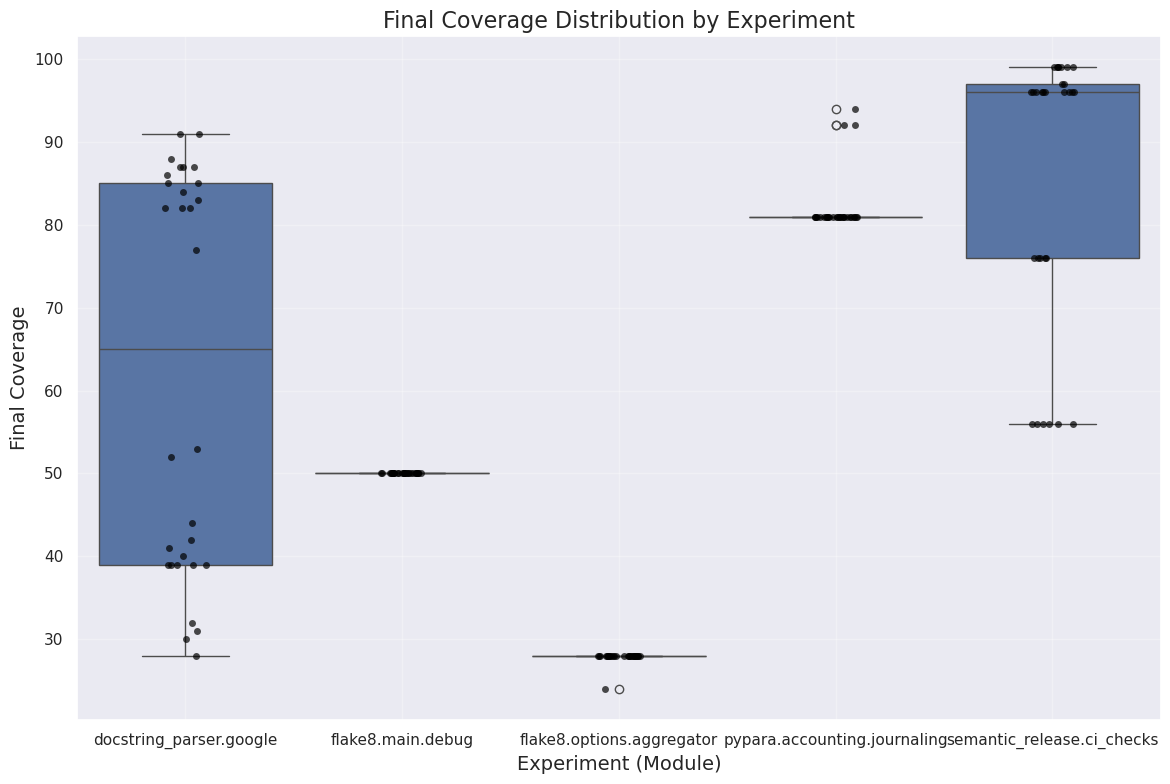

,mean,std,min,max,count
module,,,,,
docstring_parser.google,62.166667,24.020226,28,91,30
flake8.main.debug,50.000000,0.000000,50,50,30
flake8.options.aggregator,27.866667,0.730297,24,28,30
pypara.accounting.journaling,82.166667,3.572726,81,94,30
semantic_release.ci_checks,85.433333,16.933304,56,99,30


In [21]:
import seaborn as sns

# Analyze the final coverage distribution by experiment (module)
import matplotlib.pyplot as plt

# Remove rows with module == 't' (these are likely artifacts)
final_df_clean = final_df[final_df['module'] != 't']

plt.figure(figsize=(12, 8))
sns.boxplot(x='module', y='final_coverage', data=final_df_clean, order=experiments)
sns.stripplot(x='module', y='final_coverage', data=final_df_clean, color='black', size=5, alpha=0.7, order=experiments)
plt.title('Final Coverage Distribution by Experiment', fontsize=16)
plt.xlabel('Experiment (Module)', fontsize=14)
plt.ylabel('Final Coverage', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show summary statistics
summary_stats = final_df_clean.groupby('module')['final_coverage'].agg(['mean', 'std', 'min', 'max', 'count']).reindex(experiments)
display(summary_stats)